In [682]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gc


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [683]:
ls

data/  forexeda.ipynb  getdata/  models/  README.md  resources/


In [684]:
df = pd.read_pickle('data/EUR_USD_M1')
df.set_index('time', inplace=True)
df.shape
df_columns = list(df.columns)

In [685]:
df.head()

volume    close     high      low     open  complete
time                                                                     
2005-01-02 18:29:00       1 1.356000 1.356000 1.356000 1.356000      True
2005-01-02 18:38:00       1 1.356000 1.356000 1.356000 1.356000      True
2005-01-02 18:51:00       1 1.356700 1.356700 1.356700 1.356700      True
2005-01-02 18:52:00       1 1.356500 1.356500 1.356500 1.356500      True
2005-01-02 18:55:00       1 1.356800 1.356800 1.356800 1.356800      True

In [686]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4644072 entries, 2005-01-02 18:29:00 to 2017-09-05 03:34:00
Data columns (total 6 columns):
volume      int64
close       float64
high        float64
low         float64
open        float64
complete    bool
dtypes: bool(1), float64(4), int64(1)
memory usage: 217.0 MB


In [687]:
def plot_price(price_series, figtitle):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(price_series)
    ax.set_title(figtitle)    

In [688]:
df = df.loc[datetime(2016,12,6):datetime(2016,12,10)]
df.shape

(5380, 6)

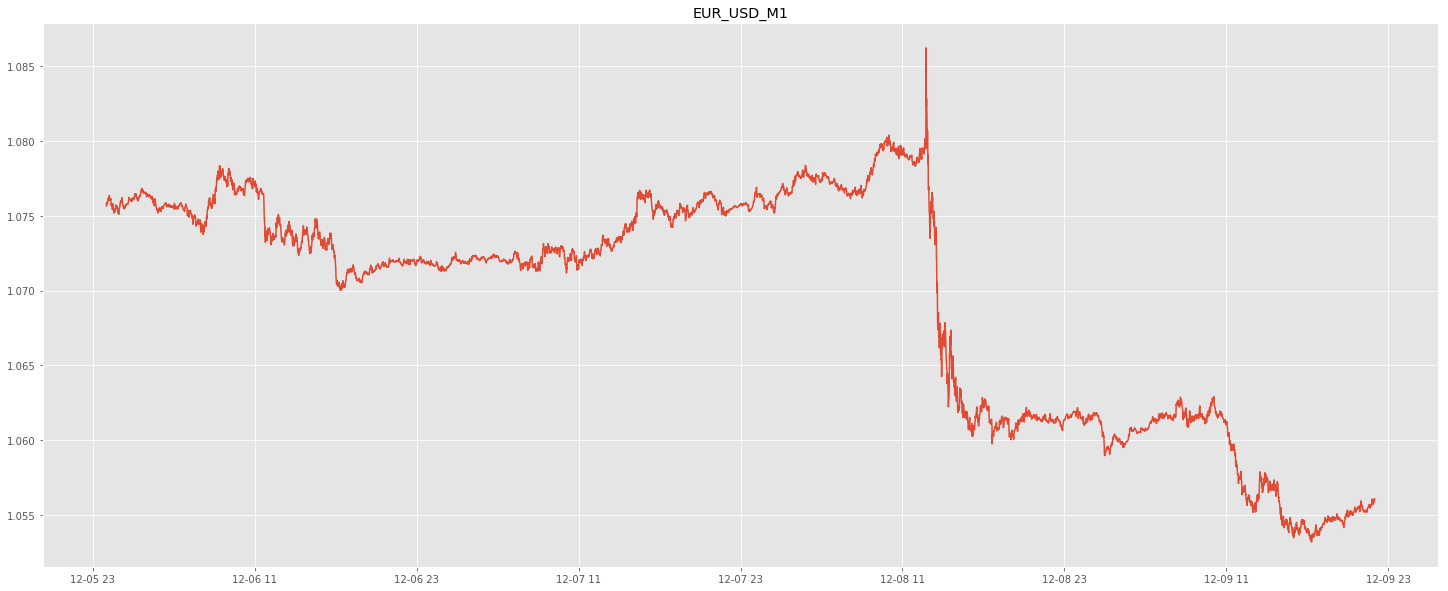

In [689]:
plot_price(df['close'], 'EUR_USD_M1')

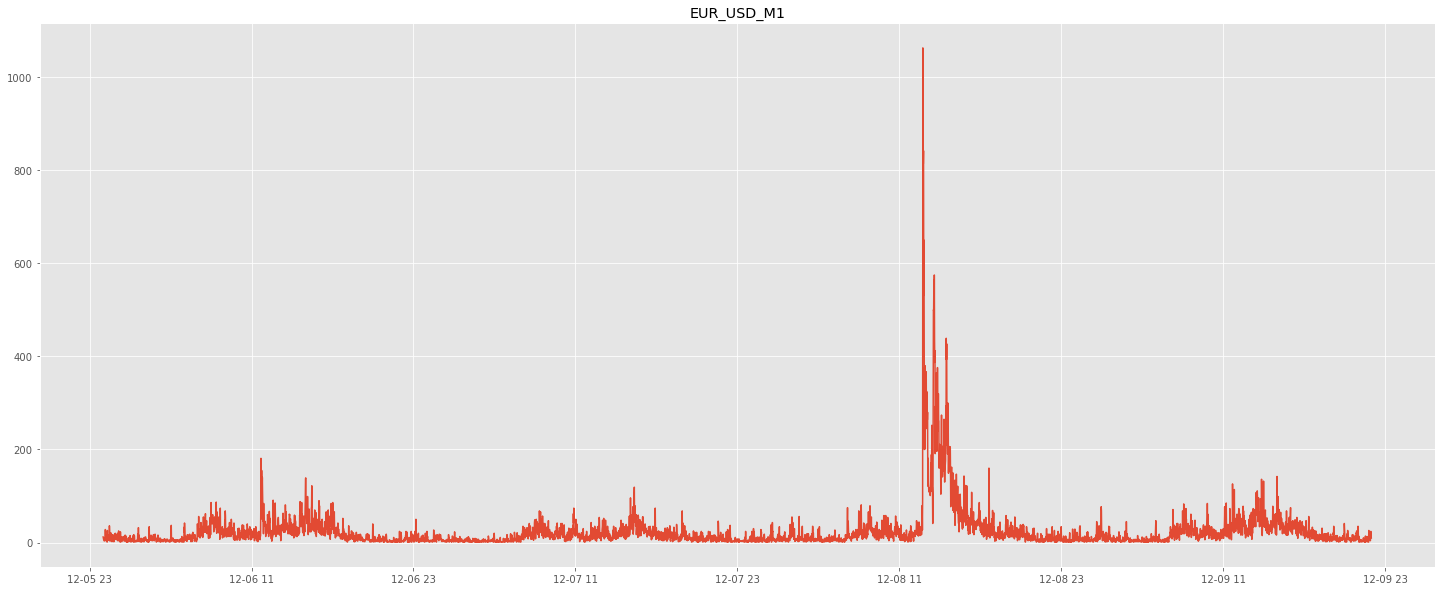

In [690]:
plot_price(df['volume'], 'EUR_USD_M1')

In [691]:
close_prices = df['close'].values.reshape(-1,1)
close_prices.shape

(5380, 1)

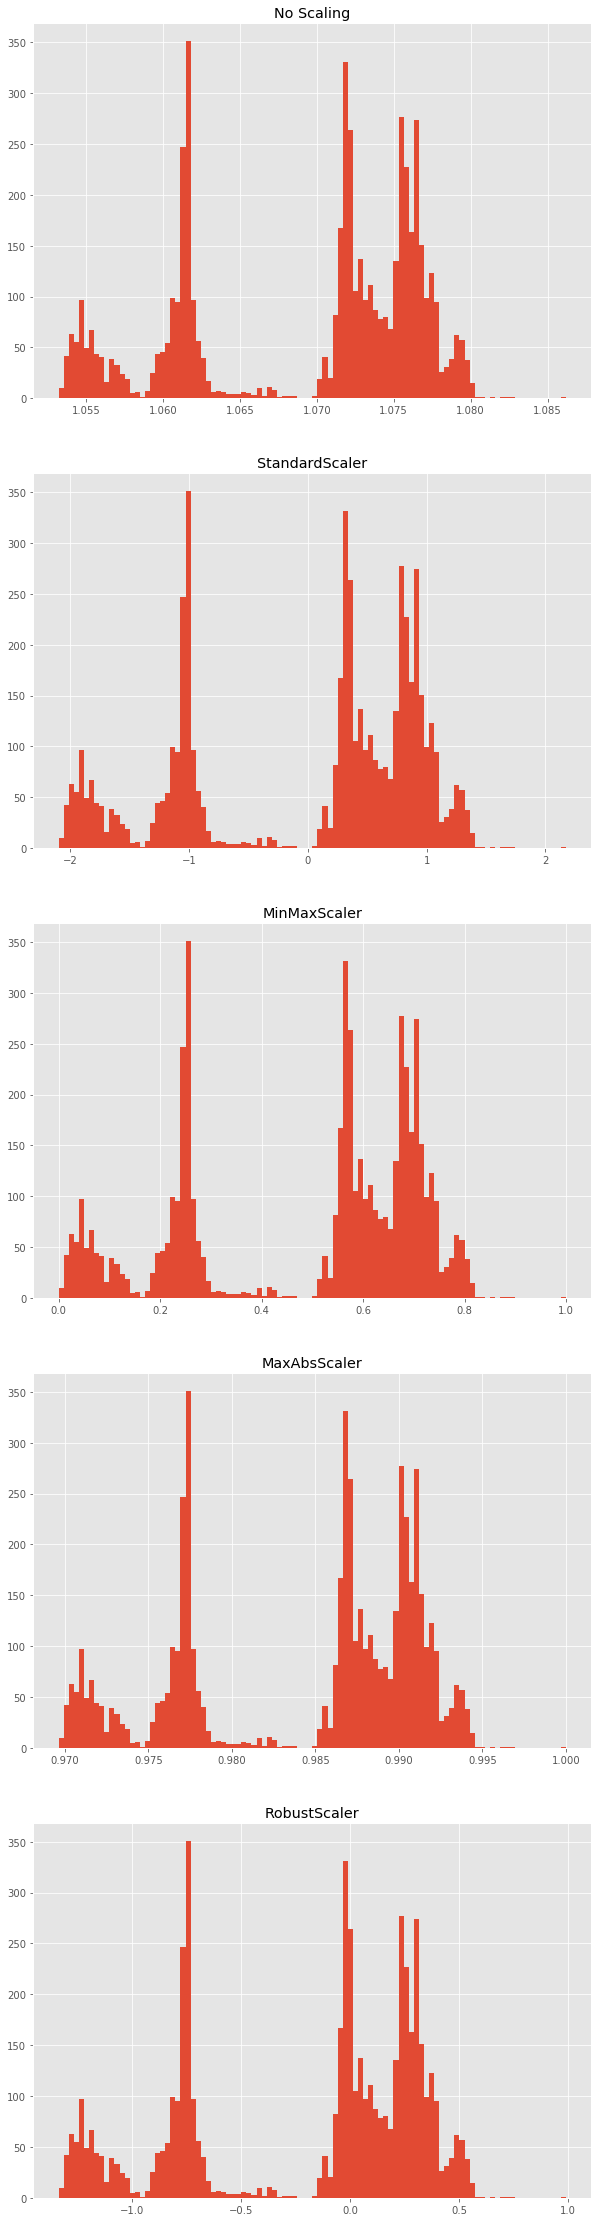

In [692]:
sc, mm, ma, rs = StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()
scalers = [sc, mm, ma, rs]
fig, axes = plt.subplots(len(scalers)+1, 1, figsize=(10,40))
for i, ax in enumerate(axes.reshape(-1)):
    if i == 0:
        ax.hist(close_prices, bins=100)
        ax.set_title('No Scaling')
    else:
        scale = scalers[i-1]
        close_prices_scaled = scale.fit_transform(close_prices)
        ax.hist(close_prices_scaled, bins=100)
        ax.set_title(scale.__class__.__name__)

In [693]:
df_values.shape

(30606, 5)

In [694]:
df.columns

Index(['volume', 'close', 'high', 'low', 'open', 'complete'], dtype='object')

# Add Target for Classification (Up / Down)

target of i day is the np.sign((open i+d) - (open i))

Exponentially smooth data before calculating features?

In [695]:
# df = pd.read_pickle('data/EUR_USD_H12')
# df.set_index('time', inplace=True)
# df.shape
# df.head()

In [696]:
def up_down(row):
    if row >= 0:
        return 1
    elif row < 0:
        return 0
    else:
        None

In [697]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['ari_returns'] = (df['close'] / df['close'].shift(1)) - 1
df['log_returns_shifted'] = np.log(df['close'].shift(-1) / df['close'])
df['target_label_direction'] = df['log_returns'].apply(up_down)
df['target_label_direction_shifted'] = df['log_returns_shifted'].apply(up_down)

In [698]:
df.head(100)

volume    close     high      low     open  complete  \
time                                                                        
2016-12-06 00:00:00      12 1.075650 1.075790 1.075620 1.075620      True   
2016-12-06 00:01:00      11 1.075880 1.075880 1.075630 1.075630      True   
2016-12-06 00:02:00       7 1.075850 1.075960 1.075850 1.075900      True   
2016-12-06 00:03:00       8 1.075740 1.075820 1.075740 1.075820      True   
2016-12-06 00:04:00       4 1.075800 1.075800 1.075720 1.075720      True   
2016-12-06 00:05:00       4 1.075850 1.075870 1.075820 1.075820      True   
2016-12-06 00:06:00       4 1.075900 1.075900 1.075820 1.075820      True   
2016-12-06 00:07:00       9 1.076120 1.076120 1.075920 1.075920      True   
2016-12-06 00:08:00       4 1.076020 1.076090 1.076020 1.076090      True   
2016-12-06 00:09:00       4 1.076020 1.076020 1.075970 1.075990      True   
2016-12-06 00:10:00      28 1.076260 1.076260 1.076040 1.076040      True   
2016-12-06 00:11:00       9 1.076200 1.076340 1.076200 1.076280      True   
2016-12-06 00:12:00      16 1.076260 1.076370 1.076200 1.076220      True   
2016-12-06 00:13:00       7 1.076350 1.076360 1.076280 1.076290      True   
2016-12-06 00:14:00      10 1.076150 1.076330 1.076120 1.076330      True   
2016-12-06 00:15:00       5 1.076020 1.076120 1.076020 1.076120      True   
2016-12-06 00:16:00       7 1.076100 1.076140 1.076040 1.076040      True   
2016-12-06 00:17:00       2 1.076100 1.076100 1.076080 1.076080      True   
2016-12-06 00:18:00       1 1.076070 1.076070 1.076070 1.076070      True   
2016-12-06 00:19:00      26 1.076130 1.076260 1.076080 1.076100      True   
2016-12-06 00:20:00       4 1.076150 1.076200 1.076150 1.076160      True   
2016-12-06 00:21:00      14 1.075830 1.076120 1.075830 1.076120      True   
2016-12-06 00:22:00      15 1.075680 1.075940 1.075680 1.075860      True   
2016-12-06 00:23:00      13 1.075760 1.075760 1.075580 1.075640      True   
2016-12-06 00:24:00      17 1.075630 1.075800 1.075580 1.075780      True   
2016-12-06 00:25:00       9 1.075690 1.075690 1.075600 1.075600      True   
2016-12-06 00:26:00       5 1.075640 1.075690 1.075630 1.075670      True   
2016-12-06 00:27:00      10 1.075420 1.075620 1.075400 1.075620      True   
2016-12-06 00:28:00      36 1.075760 1.075890 1.075380 1.075400      True   
2016-12-06 00:29:00      23 1.075800 1.075860 1.075600 1.075740      True   
...                     ...      ...      ...      ...      ...       ...   
2016-12-06 01:10:00      10 1.076200 1.076200 1.076080 1.076100      True   
2016-12-06 01:11:00      16 1.075940 1.076220 1.075940 1.076220      True   
2016-12-06 01:12:00       7 1.075790 1.075910 1.075790 1.075910      True   
2016-12-06 01:13:00       6 1.075740 1.075760 1.075720 1.075760      True   
2016-12-06 01:14:00       6 1.075710 1.075730 1.075670 1.075720      True   
2016-12-06 01:15:00       3 1.075640 1.075690 1.075640 1.075690      True   
2016-12-06 01:16:00       1 1.075660 1.075660 1.075660 1.075660      True   
2016-12-06 01:17:00      23 1.075480 1.075640 1.075440 1.075640      True   
2016-12-06 01:18:00      11 1.075660 1.075660 1.075500 1.075500      True   
2016-12-06 01:19:00       2 1.075610 1.075640 1.075610 1.075640      True   
2016-12-06 01:20:00      12 1.075460 1.075600 1.075400 1.075580      True   
2016-12-06 01:21:00       9 1.075570 1.075570 1.075480 1.075480      True   
2016-12-06 01:22:00       7 1.075540 1.075570 1.075490 1.075540      True   
2016-12-06 01:23:00       2 1.075540 1.075560 1.075540 1.075560      True   
2016-12-06 01:24:00      12 1.075580 1.075660 1.075480 1.075510      True   
2016-12-06 01:25:00       9 1.075610 1.075610 1.075510 1.075560      True   
2016-12-06 01:26:00      11 1.075700 1.075730 1.075620 1.075640      True   
2016-12-06 01:27:00       6 1.075720 1.075790 1.075720 1.075730      True   
2016-12-06 01:28:00      11 1.075710 1.075760 1.075680 1.075700      True   
2016-12-06 01:29:

In [699]:
np.log(1.34455/1.35525)

-0.0079265545770773362

In [700]:
df.tail()

volume    close     high      low     open  complete  \
time                                                                        
2016-12-09 21:55:00       4 1.055890 1.055890 1.055780 1.055780      True   
2016-12-09 21:56:00      15 1.056060 1.056060 1.055940 1.055950      True   
2016-12-09 21:57:00      24 1.056040 1.056160 1.055900 1.056010      True   
2016-12-09 21:58:00      19 1.055900 1.056040 1.055840 1.055960      True   
2016-12-09 21:59:00      10 1.056100 1.056120 1.055900 1.055900      True   

                     log_returns  ari_returns  log_returns_shifted  \
time                                                                 
2016-12-09 21:55:00     0.000095     0.000095             0.000161   
2016-12-09 21:56:00     0.000161     0.000161            -0.000019   
2016-12-09 21:57:00    -0.000019    -0.000019            -0.000133   
2016-12-09 21:58:00    -0.000133    -0.000133             0.000189   
2016-12-09 21:59:00     0.000189     0.000189                  nan   

                     target_label_direction  target_label_direction_shifted  
time                                                                         
2016-12-09 21:55:00                1.000000                        1.000000  
2016-12-09 21:56:00                1.000000                        0.000000  
2016-12-09 21:57:00                0.000000                        0.000000  
2016-12-09 21:58:00                0.000000                        1.000000  
2016-12-09 21:59:00                1.000000                             nan

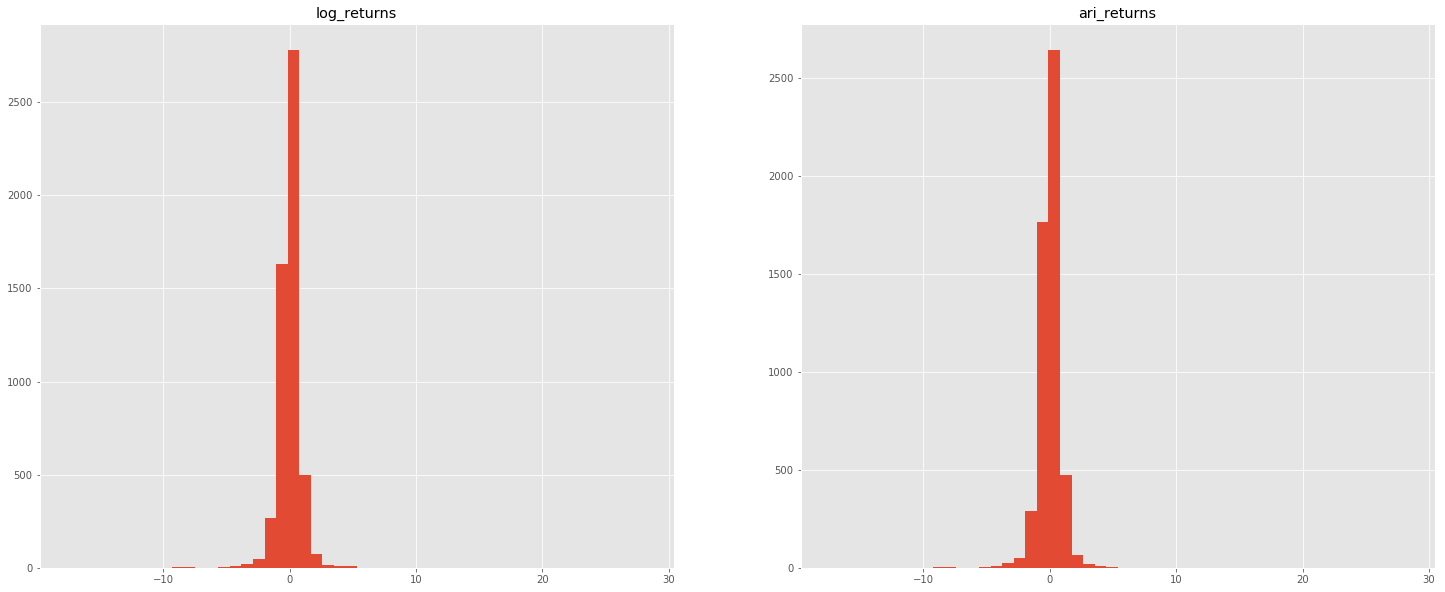

In [701]:
return_types = ['log_returns', 'ari_returns']
fig, axes = plt.subplots(1, len(return_types), figsize=(25,10))
for i, ax in enumerate(axes.reshape(-1)):
    returns = df[return_types[i]].dropna().values.reshape(-1,1)
    returns = StandardScaler().fit_transform(returns)
    ax.hist(returns, bins=50)
    ax.set_title(return_types[i])
plt.show()

# Scale

In [702]:
df.describe()

volume       close        high         low        open  \
count 5380.000000 5380.000000 5380.000000 5380.000000 5380.000000   
mean    24.340892    1.069417    1.069515    1.069321    1.069421   
std     47.711387    0.007725    0.007721    0.007728    0.007723   
min      1.000000    1.053210    1.053380    1.053100    1.053230   
25%      6.000000    1.061548    1.061630    1.061470    1.061558   
50%     13.000000    1.072170    1.072240    1.072120    1.072180   
75%     27.000000    1.075720    1.075763    1.075650    1.075712   
max   1063.000000    1.086200    1.087450    1.081200    1.086220   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count  5379.000000  5379.000000          5379.000000             5379.000000   
mean     -0.000003    -0.000003            -0.000003                0.532441   
std       0.000208     0.000208             0.000208                0.498993   
min      -0.003634    -0.003627            -0.003634                0.000000   
25%      -0.000074    -0.000074            -0.000074                0.000000   
50%       0.000000     0.000000             0.000000                1.000000   
75%       0.000074     0.000074             0.000074                1.000000   
max       0.005835     0.005853             0.005835                1.000000   

       target_label_direction_shifted  
count                     5379.000000  
mean                         0.532441  
std                          0.498993  
min                          0.000000  
25%                          0.000000  
50%                          1.000000  
75%                          1.000000  
max                          1.000000

In [703]:
df.drop('complete', axis=1, inplace=True)
scale_columns = ['volume', 'high', 'low', 'close', 'open']
ss = StandardScaler()
scale_values = ss.fit_transform(df[scale_columns])
df[scale_columns] = scale_values
print(df.describe())
print(df.shape)
print(df.columns)

           volume       close        high         low        open  \
count 5380.000000 5380.000000 5380.000000 5380.000000 5380.000000   
mean    -0.000000    0.000000    0.000000   -0.000000   -0.000000   
std      1.000093    1.000093    1.000093    1.000093    1.000093   
min     -0.489256   -2.098125   -2.090030   -2.099068   -2.096567   
25%     -0.384449   -1.018757   -1.021348   -1.015935   -1.018258   
50%     -0.237720    0.356425    0.353042    0.362245    0.357225   
75%      0.055738    0.816006    0.809337    0.819050    0.814640   
max     21.771651    2.172740    2.323304    1.537256    2.175233   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count  5379.000000  5379.000000          5379.000000             5379.000000   
mean     -0.000003    -0.000003            -0.000003                0.532441   
std       0.000208     0.000208             0.000208                0.498993   
min      -0.003634    -0.003627            -0.003634      

In [704]:
df.head()

volume    close     high      low     open  \
time                                                                
2016-12-06 00:00:00 -0.258681 0.806944 0.812899 0.815168 0.802663   
2016-12-06 00:01:00 -0.279643 0.836719 0.824558 0.816462 0.803958   
2016-12-06 00:02:00 -0.363488 0.832836 0.834921 0.844931 0.838919   
2016-12-06 00:03:00 -0.342526 0.818595 0.816785 0.830697 0.828560   
2016-12-06 00:04:00 -0.426372 0.826363 0.814195 0.828109 0.815612   

                     log_returns  ari_returns  log_returns_shifted  \
time                                                                 
2016-12-06 00:00:00          nan          nan             0.000214   
2016-12-06 00:01:00     0.000214     0.000214            -0.000028   
2016-12-06 00:02:00    -0.000028    -0.000028            -0.000102   
2016-12-06 00:03:00    -0.000102    -0.000102             0.000056   
2016-12-06 00:04:00     0.000056     0.000056             0.000046   

                     target_label_direction  target_label_direction_shifted  
time                                                                         
2016-12-06 00:00:00                     nan                        1.000000  
2016-12-06 00:01:00                1.000000                        0.000000  
2016-12-06 00:02:00                0.000000                        0.000000  
2016-12-06 00:03:00                0.000000                        1.000000  
2016-12-06 00:04:00                1.000000                        1.000000

# Add Features pandas

In [705]:
# df['20d_ma'] = df['close'].rolling(window=20).mean()
# df['50d_ma'] = df['close'].rolling(window=50).mean()
# df['Bol_upper'] = df['close'].rolling(window=20).mean() + 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_lower'] = df['close'].rolling(window=20).mean() - 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_BW'] = ((df['Bol_upper'] - df['Bol_lower'])/df['20d_ma'])*100
# df['Bol_BW_200MA'] = df['Bol_BW'].rolling(window=50).mean()
# df['20d_exma'] = df['close'].ewm(span=20).mean()
# df['50d_exma'] = df['close'].ewm(span=50).mean()

In [706]:
# df.plot(y=['close','20d_ma','50d_ma','Bol_upper','Bol_lower'], figsize=(25,10))

In [707]:
# df.plot(y=['close', '20d_exma','50d_exma'], figsize=(25,10))

In [708]:
# df.plot(y=['Bol_BW','Bol_BW_200MA'], figsize=(25,10))

# Add Features TA-Lib

In [709]:
print(talib.get_function_groups().keys())

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])


In [710]:
mom_ind = talib.get_function_groups()['Momentum Indicators']
over_stud = talib.get_function_groups()['Overlap Studies']
volu_ind = talib.get_function_groups()['Volume Indicators']
cyc_ind = talib.get_function_groups()['Cycle Indicators']
vola_ind = talib.get_function_groups()['Volatility Indicators']
talib_abstract_fun_list = mom_ind + over_stud + volu_ind + cyc_ind + vola_ind

In [711]:
print(talib.get_functions())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

In [712]:
talib.abstract.__all__

['Function',
 'CDLDARKCLOUDCOVER',
 'HT_TRENDMODE',
 'STOCHF',
 'CDLHOMINGPIGEON',
 'HT_PHASOR',
 'MAVP',
 'ULTOSC',
 'ROCP',
 'CDLGRAVESTONEDOJI',
 'CDLKICKING',
 'SINH',
 'LOG10',
 'STOCH',
 'SAR',
 'TYPPRICE',
 'ADOSC',
 'T3',
 'CDLSTICKSANDWICH',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'MINUS_DM',
 'MIN',
 'MIDPRICE',
 'ASIN',
 'MACDEXT',
 'MULT',
 'CDLCONCEALBABYSWALL',
 'ACOS',
 'MINUS_DI',
 'CDLDOJI',
 'CDL3WHITESOLDIERS',
 'CORREL',
 'STOCHRSI',
 'COS',
 'AROONOSC',
 'LINEARREG_INTERCEPT',
 'LINEARREG',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'RSI',
 'CDLSPINNINGTOP',
 'MA',
 'MININDEX',
 'ADXR',
 'CDLHIKKAKEMOD',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLTRISTAR',
 'WILLR',
 'ROC',
 'DX',
 'AD',
 'CEIL',
 'COSH',
 'CDLHARAMI',
 'LINEARREG_SLOPE',
 'CDLMATHOLD',
 'MEDPRICE',
 'ROCR',
 'ROCR100',
 'TANH',
 'TRIMA',
 'CDL2CROWS',
 'WCLPRICE',
 'WMA',
 'ADD',
 'BETA',
 'DEMA',
 'MACD',
 'EXP',
 'CDLHIGHWAVE',
 'CDLDOJISTAR',
 'CDLMATCHINGLOW',
 'HT_TRENDLINE',
 'C

In [713]:
# talib_abstract_fun_list = talib.abstract.__all__[1:]
talib_abstract_fun_list = [i for i in talib_abstract_fun_list if i not in ['MAVP','ASIN', 'ACOS']]
print(len(talib_abstract_fun_list))

57


In [714]:
talib_abstract_fun_list

['ADX',
 'ADXR',
 'APO',
 'AROON',
 'AROONOSC',
 'BOP',
 'CCI',
 'CMO',
 'DX',
 'MACD',
 'MACDEXT',
 'MACDFIX',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'MOM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCP',
 'ROCR',
 'ROCR100',
 'RSI',
 'STOCH',
 'STOCHF',
 'STOCHRSI',
 'TRIX',
 'ULTOSC',
 'WILLR',
 'BBANDS',
 'DEMA',
 'EMA',
 'HT_TRENDLINE',
 'KAMA',
 'MA',
 'MAMA',
 'MIDPOINT',
 'MIDPRICE',
 'SAR',
 'SAREXT',
 'SMA',
 'T3',
 'TEMA',
 'TRIMA',
 'WMA',
 'AD',
 'ADOSC',
 'OBV',
 'HT_DCPERIOD',
 'HT_DCPHASE',
 'HT_PHASOR',
 'HT_SINE',
 'HT_TRENDMODE',
 'ATR',
 'NATR',
 'TRANGE']

In [715]:
ohlcv = {
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'volume': df['volume'].astype(float)
}

In [716]:
# talib_abstract_fun_list = ['RSI', 'STOCH', 'WILLR', 'ATR', 'MACD']

In [717]:
for fun in talib_abstract_fun_list:
    res = getattr(talib.abstract, fun)(ohlcv)
    if len(res) > 10:
        df[fun] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+str(i+1)] = val

In [718]:
for per in [3,6,12,18,25, 30]:
    col_name = 'MAVP_'+str(per)
    df[col_name] = talib.MAVP(df['close'].values, periods=np.array([float(per)]*df.shape[0]))

In [719]:
df.head(100)

volume    close     high      low     open  \
time                                                                
2016-12-06 00:00:00 -0.258681 0.806944 0.812899 0.815168 0.802663   
2016-12-06 00:01:00 -0.279643 0.836719 0.824558 0.816462 0.803958   
2016-12-06 00:02:00 -0.363488 0.832836 0.834921 0.844931 0.838919   
2016-12-06 00:03:00 -0.342526 0.818595 0.816785 0.830697 0.828560   
2016-12-06 00:04:00 -0.426372 0.826363 0.814195 0.828109 0.815612   
2016-12-06 00:05:00 -0.426372 0.832836 0.823262 0.841049 0.828560   
2016-12-06 00:06:00 -0.426372 0.839309 0.827148 0.841049 0.828560   
2016-12-06 00:07:00 -0.321565 0.867790 0.855647 0.853990 0.841509   
2016-12-06 00:08:00 -0.426372 0.854844 0.851761 0.866931 0.863522   
2016-12-06 00:09:00 -0.426372 0.854844 0.842693 0.860460 0.850573   
2016-12-06 00:10:00  0.076700 0.885914 0.873782 0.869519 0.857048   
2016-12-06 00:11:00 -0.321565 0.878146 0.884145 0.890224 0.888125   
2016-12-06 00:12:00 -0.174836 0.885914 0.888031 0.890224 0.880356   
2016-12-06 00:13:00 -0.363488 0.897565 0.886736 0.900576 0.889420   
2016-12-06 00:14:00 -0.300604 0.871673 0.882849 0.879871 0.894599   
2016-12-06 00:15:00 -0.405410 0.854844 0.855647 0.866931 0.867407   
2016-12-06 00:16:00 -0.363488 0.865201 0.858237 0.869519 0.857048   
2016-12-06 00:17:00 -0.468294 0.865201 0.853056 0.874695 0.862227   
2016-12-06 00:18:00 -0.489256 0.861317 0.849170 0.873401 0.860932   
2016-12-06 00:19:00  0.034777 0.869084 0.873782 0.874695 0.864817   
2016-12-06 00:20:00 -0.426372 0.871673 0.866010 0.883753 0.872586   
2016-12-06 00:21:00 -0.216759 0.830246 0.855647 0.842343 0.867407   
2016-12-06 00:22:00 -0.195797 0.810828 0.832330 0.822932 0.833740   
2016-12-06 00:23:00 -0.237720 0.821184 0.809013 0.809992 0.805253   
2016-12-06 00:24:00 -0.153875 0.804355 0.814195 0.809992 0.823381   
2016-12-06 00:25:00 -0.321565 0.812122 0.799946 0.812580 0.800073   
2016-12-06 00:26:00 -0.405410 0.805649 0.799946 0.816462 0.809137   
2016-12-06 00:27:00 -0.300604 0.777168 0.790878 0.786698 0.802663   
2016-12-06 00:28:00  0.244390 0.821184 0.825853 0.784110 0.774176   
2016-12-06 00:29:00 -0.028107 0.826363 0.821967 0.812580 0.818201   
...                       ...      ...      ...      ...      ...   
2016-12-06 01:10:00 -0.300604 0.878146 0.866010 0.874695 0.864817   
2016-12-06 01:11:00 -0.174836 0.844487 0.868600 0.856578 0.880356   
2016-12-06 01:12:00 -0.363488 0.825068 0.828444 0.837167 0.840214   
2016-12-06 01:13:00 -0.384449 0.818595 0.809013 0.828109 0.820791   
2016-12-06 01:14:00 -0.384449 0.814711 0.805127 0.821638 0.815612   
2016-12-06 01:15:00 -0.447333 0.805649 0.799946 0.817756 0.811727   
2016-12-06 01:16:00 -0.489256 0.808238 0.796060 0.820344 0.807842   
2016-12-06 01:17:00 -0.028107 0.784936 0.793469 0.791875 0.805253   
2016-12-06 01:18:00 -0.279643 0.808238 0.796060 0.799639 0.787124   
2016-12-06 01:19:00 -0.468294 0.801765 0.793469 0.813874 0.805253   
2016-12-06 01:20:00 -0.258681 0.782347 0.788287 0.786698 0.797483   
2016-12-06 01:21:00 -0.321565 0.796587 0.784401 0.797051 0.784535   
2016-12-06 01:22:00 -0.363488 0.792703 0.784401 0.798345 0.792304   
2016-12-06 01:23:00 -0.468294 0.792703 0.783106 0.804815 0.794894   
2016-12-06 01:24:00 -0.258681 0.797882 0.796060 0.797051 0.788419   
2016-12-06 01:25:00 -0.321565 0.801765 0.789583 0.800933 0.794894   
2016-12-06 01:26:00 -0.279643 0.813417 0.805127 0.815168 0.805253   
2016-12-06 01:27:00 -0.384449 0.816006 0.812899 0.828109 0.816907   
2016-12-06 01:28:00 -0.279643 0.814711 0.809013 0.822932 0.813022   
2016-12-06 01:29:00 -0.300604 0.813417 0.802536 0.809992 0.810432   
2016-12-06 01:30:00 -0.300604 0.822479 0.814195 0.821638 0.810432   
2016-12-06 01:32:00 -0.237720 0.826363 0.819376 0.830697 0.818201   
2016-12-06 01:33:00 -0.342526 0.827657 0.824558 0.839755 0.831150   
2016-12-06 01:34:00 -0.447333 0.823774 0.814195 0.835873 0.823381   
2016-12-06 01:35:00 -0.426372 0.822479 0.818081 0.834579 0.825971   
2016-12-06 01:36:00 -

In [720]:
list(df.columns)

['volume',
 'close',
 'high',
 'low',
 'open',
 'log_returns',
 'ari_returns',
 'log_returns_shifted',
 'target_label_direction',
 'target_label_direction_shifted',
 'ADX',
 'ADXR',
 'APO',
 'AROON_1',
 'AROON_2',
 'AROONOSC',
 'BOP',
 'CCI',
 'CMO',
 'DX',
 'MACD_1',
 'MACD_2',
 'MACD_3',
 'MACDEXT_1',
 'MACDEXT_2',
 'MACDEXT_3',
 'MACDFIX_1',
 'MACDFIX_2',
 'MACDFIX_3',
 'MFI',
 'MINUS_DI',
 'MINUS_DM',
 'MOM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCP',
 'ROCR',
 'ROCR100',
 'RSI',
 'STOCH_1',
 'STOCH_2',
 'STOCHF_1',
 'STOCHF_2',
 'STOCHRSI_1',
 'STOCHRSI_2',
 'TRIX',
 'ULTOSC',
 'WILLR',
 'BBANDS_1',
 'BBANDS_2',
 'BBANDS_3',
 'DEMA',
 'EMA',
 'HT_TRENDLINE',
 'KAMA',
 'MA',
 'MAMA_1',
 'MAMA_2',
 'MIDPOINT',
 'MIDPRICE',
 'SAR',
 'SAREXT',
 'SMA',
 'T3',
 'TEMA',
 'TRIMA',
 'WMA',
 'AD',
 'ADOSC',
 'OBV',
 'HT_DCPERIOD',
 'HT_DCPHASE',
 'HT_PHASOR_1',
 'HT_PHASOR_2',
 'HT_SINE_1',
 'HT_SINE_2',
 'HT_TRENDMODE',
 'ATR',
 'NATR',
 'TRANGE',
 'MAVP_3',
 'MAVP_6',
 'MAVP_12',
 '

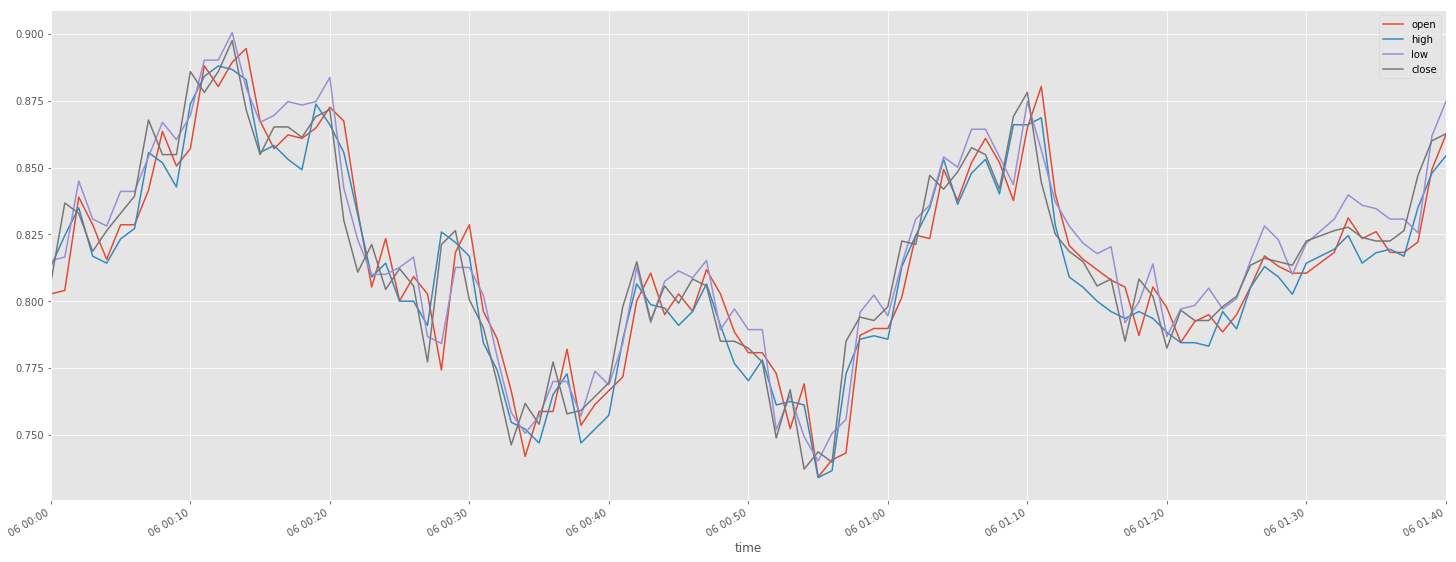

In [721]:
df.iloc[:100].plot(y=['open', 'high', 'low', 'close'], figsize=(25,10))

In [722]:
# for indi in df.columns:
#     df.plot(y=[indi], figsize=(25,10))

In [723]:
# df.iloc[:300].plot(y=['MAC'], figsize=(25,10))

In [724]:
# for col in df.columns:
#     if df[col].isnull().all():
#         print(col)
#         df.drop(col, axis=1, inplace=True)
# df.drop(['ASIN', 'ACOS'],axis=1, inplace=True)

In [725]:
df.shape[0] - df.dropna().shape[0]

89

In [726]:
drop_columns = ['volume', 'close', 'high', 'low', 'open', 'complete', 'log_returns', 'ari_returns', 'log_returns_shifted', 'target_label_direction', 'target_label_direction_shifted']
predict_columns = [i for i in df.columns if i not in drop_columns]
print(predict_columns)
print(len(predict_columns))

['ADX', 'ADXR', 'APO', 'AROON_1', 'AROON_2', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD_1', 'MACD_2', 'MACD_3', 'MACDEXT_1', 'MACDEXT_2', 'MACDEXT_3', 'MACDFIX_1', 'MACDFIX_2', 'MACDFIX_3', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH_1', 'STOCH_2', 'STOCHF_1', 'STOCHF_2', 'STOCHRSI_1', 'STOCHRSI_2', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS_1', 'BBANDS_2', 'BBANDS_3', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_1', 'MAMA_2', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_1', 'HT_PHASOR_2', 'HT_SINE_1', 'HT_SINE_2', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE', 'MAVP_3', 'MAVP_6', 'MAVP_12', 'MAVP_18', 'MAVP_25', 'MAVP_30']
78


In [727]:
df.describe()

volume       close        high         low        open  \
count 5380.000000 5380.000000 5380.000000 5380.000000 5380.000000   
mean    -0.000000    0.000000    0.000000   -0.000000   -0.000000   
std      1.000093    1.000093    1.000093    1.000093    1.000093   
min     -0.489256   -2.098125   -2.090030   -2.099068   -2.096567   
25%     -0.384449   -1.018757   -1.021348   -1.015935   -1.018258   
50%     -0.237720    0.356425    0.353042    0.362245    0.357225   
75%      0.055738    0.816006    0.809337    0.819050    0.814640   
max     21.771651    2.172740    2.323304    1.537256    2.175233   

       log_returns  ari_returns  log_returns_shifted  target_label_direction  \
count  5379.000000  5379.000000          5379.000000             5379.000000   
mean     -0.000003    -0.000003            -0.000003                0.532441   
std       0.000208     0.000208             0.000208                0.498993   
min      -0.003634    -0.003627            -0.003634                0.000000   
25%      -0.000074    -0.000074            -0.000074                0.000000   
50%       0.000000     0.000000             0.000000                1.000000   
75%       0.000074     0.000074             0.000074                1.000000   
max       0.005835     0.005853             0.005835                1.000000   

       target_label_direction_shifted         ADX        ADXR         APO  \
count                     5379.000000 5353.000000 5340.000000 5355.000000   
mean                         0.532441   23.470242   23.462097   -0.003435   
std                          0.498993    9.778994    8.912277    0.039962   
min                          0.000000    7.804849    9.370948   -0.397830   
25%                          0.000000   16.581952   17.168241   -0.015427   
50%                          1.000000   21.078191   21.406710   -0.000232   
75%                          1.000000   27.937574   27.423748    0.014917   
max                          1.000000   66.080228   58.888064    0.143053   

          AROON_1     AROON_2    AROONOSC         BOP         CCI         CMO  \
count 5366.000000 5366.000000 5366.000000 5380.000000 5367.000000 5366.000000   
mean    49.804324   49.978702    0.174378    0.050304    0.394093    0.036897   
std     36.121757   35.962782   62.568129   10.217028  106.892577   21.612626   
min      0.000000    0.000000 -100.000000 -293.835982 -379.051937  -81.626879   
25%     14.285714   14.285714  -57.142857    0.000000  -85.125054  -14.615109   
50%     50.000000   50.000000    7.142857    0.000000    1.152480    0.033466   
75%     85.714286   85.714286   57.142857    0.000000   87.099221   14.785352   
max    100.000000  100.000000  100.000000  465.279117  450.288480   76.621615   

               DX      MACD_1      MACD_2      MACD_3   MACDEXT_1   MACDEXT_2  \
count 5366.000000 5347.000000 5347.000000 5347.000000 5347.000000 5347.000000   
mean    23.499582   -0.003425   -0.003441    0.000017   -0.003412   -0.003442   
std     16.864926    0.029139    0.027607    0.008329    0.039985    0.037921   
min      0.002295   -0.284787   -0.258420   -0.086455   -0.397830   -0.370201   
25%      9.700409   -0.011528   -0.010959   -0.003479   -0.015369   -0.014519   
50%     20.638709    0.000016   -0.000228   -0.000112   -0.000174   -0.000144   
75%     33.854531    0.010653    0.009969    0.003686    0.014950    0.014078   
max     85.386438    0.114974    0.080323    0.063653    0.143053    0.113046   

        MACDEXT_3   MACDFIX_1   MACDFIX_2   MACDFIX_3         MFI    MINUS_DI  \
count 5347.000000 5347.000000 5347.000000 5347.000000 5366.000000 5366.000000   
mean     0.000030   -0.003262   -0.003278    0.000016   15.863497   35.804065   
std      0.018926    0.027745    0.026297    0.007903   27.829786   13.724421   
min     -0.204077   -0.270989   -0.245868   -0.081980  -72.784294    4.185460   
25%     -0.007559   -0.010946   -0.010423   -0.003301    0.000000   25.790836   
50%     -0.000077    0.00003

In [728]:
df.shape

(5380, 88)

In [729]:
df.dropna(inplace=True)
df.shape

(5291, 88)

In [730]:
y = df['target_label_direction_shifted']
x = df[predict_columns]
print(x.shape, y.shape)
up = sum(y == 1) / len(y) * 100
print('up: {:.2f}%\ndown: {:.2f}%'.format(up, 100-up))

(5291, 78) (5291,)
up: 53.26%
down: 46.74%


In [731]:
ss = StandardScaler()
x_ss = ss.fit_transform(x)
x_ss = pd.DataFrame(x, columns=predict_columns)

In [732]:
x_ss.describe()

ADX        ADXR         APO     AROON_1     AROON_2    AROONOSC  \
count 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000   
mean    23.530652   23.513442   -0.003420   49.732700   50.017550    0.284850   
std      9.812857    8.933378    0.040130   36.089922   35.961468   62.490506   
min      7.804849    9.370948   -0.397830    0.000000    0.000000 -100.000000   
25%     16.589514   17.187664   -0.015315   14.285714   14.285714  -57.142857   
50%     21.159915   21.501109   -0.000149   50.000000   50.000000    7.142857   
75%     28.032353   27.467966    0.014963   85.714286   85.714286   57.142857   
max     66.080228   58.888064    0.143053  100.000000  100.000000  100.000000   

              BOP         CCI         CMO          DX      MACD_1      MACD_2  \
count 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000   
mean     0.052023    0.690117    0.022660   23.572698   -0.003425   -0.003436   
std     10.287128  106.930572   21.667076   16.906471    0.029264    0.027731   
min   -293.835982 -379.051937  -81.626879    0.028819   -0.284787   -0.258420   
25%      0.000000  -84.744062  -14.661904    9.738203   -0.011509   -0.010905   
50%      0.000000    1.392654    0.111073   20.666690    0.000099   -0.000141   
75%      0.000000   87.289694   14.790192   33.970136    0.010668    0.010020   
max    465.279117  450.288480   76.621615   85.386438    0.114974    0.080323   

           MACD_3   MACDEXT_1   MACDEXT_2   MACDEXT_3   MACDFIX_1   MACDFIX_2  \
count 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000   
mean     0.000011   -0.003420   -0.003447    0.000027   -0.003262   -0.003273   
std      0.008353    0.040130    0.038062    0.018973    0.027864    0.026414   
min     -0.086455   -0.397830   -0.370201   -0.204077   -0.270989   -0.245868   
25%     -0.003473   -0.015315   -0.014425   -0.007552   -0.010940   -0.010367   
50%     -0.000111   -0.000149   -0.000128   -0.000089    0.000080   -0.000139   
75%      0.003659    0.014963    0.014100    0.007943    0.010141    0.009512   
max      0.063653    0.143053    0.113046    0.168632    0.108805    0.076178   

        MACDFIX_3         MFI    MINUS_DI    MINUS_DM         MOM     PLUS_DI  \
count 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000 5291.000000   
mean     0.000011   16.079451   35.722872    0.098375   -0.004823   35.814813   
std      0.007925   27.959358   13.762113    0.094893    0.081369   13.034425   
min     -0.081980  -72.784294    4.185460    0.008869   -1.216918    3.985552   
25%     -0.003293    0.000000   25.733614    0.053091   -0.033012   25.778604   
50%     -0.000108    0.000000   33.840765    0.073925    0.000000   34.484160   
75%      0.003472   33.314269   44.188270    0.109403    0.032365   44.962631   
max      0.060307  215.669368   87.463300    1.096456    0.885502   77.030182   

          PLUS_DM           PPO         ROC        ROCP        ROCR  \
count 5291.000000   5291.000000 5291.000000 5291.000000 5291.000000   
mean     0.092023     -2.135095    0.535438    0.005354    1.005354   
std      0.066005    157.716673   20.643624    0.206436    0.206436   
min      0.016830 -11363.719592 -862.516526   -8.625165   -7.625165   
25%      0.055795     -1.611611   -3.539813   -0.035398    0.964602   
50%      0.077689      0.029435    0.241639    0.002416    1.002416   
75%      0.108230      2.189451    4.481985    0.044820    1.044820   
max      1.099823    901.357725  316.674577    3.166746    4.166746   

          ROCR100         RSI       STOCH_1       STOCH_2      STOCHF_1  \
count 5291.000000 5291.000000   5291.000000   5291.000000   5291.000000   
mean   100.535438   50.011330     27.945013     27.909302     27.926581   
std     20.643624   10.833538    828.244201    695.759428   1424.432594   
min   -762.516526    9.186561 -32247.525810 -32209.284097 -96747.179860   
25%     96.460187   42.669048      2.721962      6.932909     -7.708833   
50% 

In [733]:
pca = PCA(n_components=len(predict_columns)-1)

In [734]:
pca.fit(x_ss)

PCA(copy=True, iterated_power='auto', n_components=77, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[ 72.14  95.57  98.02  98.65  99.2   99.49  99.72  99.79  99.86  99.88
  99.9   99.92  99.94  99.95  99.96  99.97  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98  99.98
  99.98  99.98  99.98  99.98  99.98  99.98  99.98]


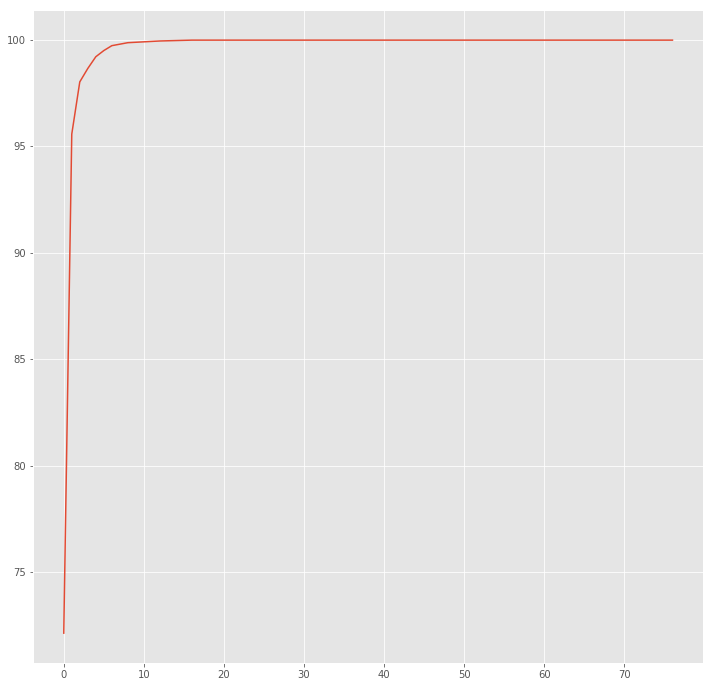

In [735]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)

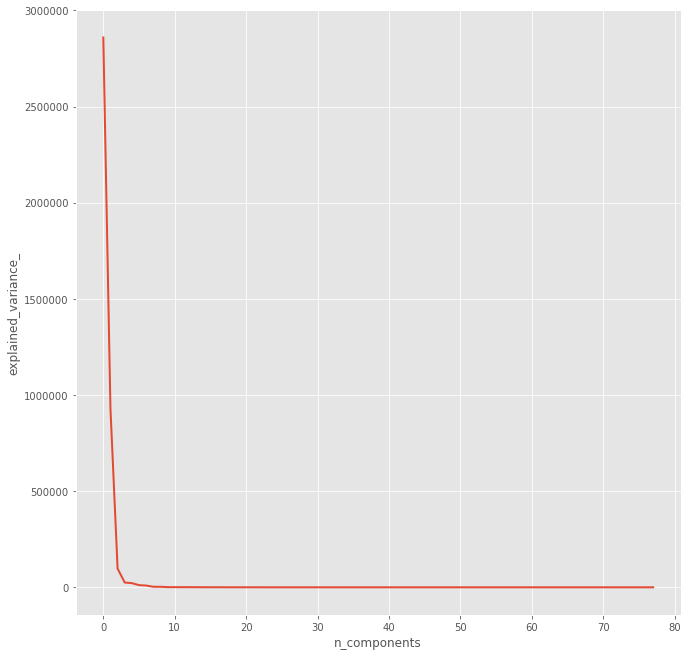

In [736]:
# Plot the PCA spectrum
pca = PCA()
pca.fit(x_ss)
plt.figure(1)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [737]:
pca = PCA(n_components=5)
pca.fit(x)
x_ss=pca.fit_transform(x)
type(x_ss)

numpy.ndarray

In [739]:
print(x_ss.shape)

(5291, 5)


In [740]:
split_index = int(df.shape[0]*.5)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
y_test = pd.Series(y_test.values)

(2645, 78) (2646, 78)
(2645,) (2646,)


In [741]:
# x_train, x_test, y_train, y_test = train_test_split(x, y)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Model

In [742]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [743]:
for mod in models:
    #print(mod.steps[1][1].__class__.__name__)
    print(mod.__class__.__name__)
    print(np.mean(cross_val_score(mod, x, y, cv=3, n_jobs=-1)))

LogisticRegression
0.506325866342
DecisionTreeClassifier
0.522015171795
RandomForestClassifier
0.492915918816
AdaBoostClassifier
0.51087301294
GradientBoostingClassifier
0.505202148668


In [744]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [745]:
for mod in models:
    mod.fit(x_train, y_train)

In [746]:
df.head()

volume    close     high      low     open  \
time                                                                
2016-12-06 01:28:00 -0.279643 0.814711 0.809013 0.822932 0.813022   
2016-12-06 01:29:00 -0.300604 0.813417 0.802536 0.809992 0.810432   
2016-12-06 01:30:00 -0.300604 0.822479 0.814195 0.821638 0.810432   
2016-12-06 01:32:00 -0.237720 0.826363 0.819376 0.830697 0.818201   
2016-12-06 01:33:00 -0.342526 0.827657 0.824558 0.839755 0.831150   

                     log_returns  ari_returns  log_returns_shifted  \
time                                                                 
2016-12-06 01:28:00    -0.000009    -0.000009            -0.000009   
2016-12-06 01:29:00    -0.000009    -0.000009             0.000065   
2016-12-06 01:30:00     0.000065     0.000065             0.000028   
2016-12-06 01:32:00     0.000028     0.000028             0.000009   
2016-12-06 01:33:00     0.000009     0.000009            -0.000028   

                     target_label_direction  target_label_direction_shifted  \
time                                                                          
2016-12-06 01:28:00                0.000000                        0.000000   
2016-12-06 01:29:00                0.000000                        1.000000   
2016-12-06 01:30:00                1.000000                        1.000000   
2016-12-06 01:32:00                1.000000                        1.000000   
2016-12-06 01:33:00                1.000000                        0.000000   

                          ADX      ADXR       APO   AROON_1    AROON_2  \
time                                                                     
2016-12-06 01:28:00 16.621810 17.107051 -0.021228 42.857143  92.857143   
2016-12-06 01:29:00 16.290099 16.399071 -0.017560 35.714286  85.714286   
2016-12-06 01:30:00 15.276139 15.981661 -0.015626 28.571429 100.000000   
2016-12-06 01:32:00 14.330946 15.522526 -0.012730 21.428571 100.000000   
2016-12-06 01:33:00 13.745906 15.242506 -0.007809 14.285714 100.000000   

                     AROONOSC      BOP        CCI       CMO        DX  \
time                                                                    
2016-12-06 01:28:00 50.000000 0.000000 115.023402  4.655221  2.221892   
2016-12-06 01:29:00 50.000000 0.000000  59.400723  3.610455 11.977853   
2016-12-06 01:30:00 71.428571 0.000000 124.905504 10.356649  2.094666   
2016-12-06 01:32:00 78.571429 0.000000 134.941956 13.161746  2.043431   
2016-12-06 01:33:00 85.714286 0.000000 133.501111 14.126359  6.140384   

                       MACD_1    MACD_2   MACD_3  MACDEXT_1  MACDEXT_2  \
time                                                                     
2016-12-06 01:28:00 -0.001552 -0.002016 0.000463  -0.021228  -0.015805   
2016-12-06 01:29:00 -0.000955 -0.001804 0.000848  -0.017560  -0.018157   
2016-12-06 01:30:00  0.000246 -0.001394 0.001640  -0.015626  -0.019395   
2016-12-06 01:32:00  0.001494 -0.000816 0.002311  -0.012730  -0.019294   
2016-12-06 01:33:00  0.002559 -0.000141 0.002700  -0.007809  -0.018133   

                     MACDEXT_3  MACDFIX_1  MACDFIX_2  MACDFIX_3      MFI  \
time                                                                       
2016-12-06 01:28:00  -0.005423  -0.001492  -0.001874   0.000382 0.000000   
2016-12-06 01:29:00   0.000597  -0.000931  -0.001685   0.000754 0.000000   
2016-12-06 01:30:00   0.003769   0.000200  -0.001308   0.001508 0.000000   
2016-12-06 01:32:00   0.006563   0.001378  -0.000771   0.002149 0.000000   
2016-12-06 01:33:00   0.010324   0.002387  -0.000139   0.002526 0.000000   

                     MINUS_DI  MINUS_DM      MOM   PLUS_DI  PLUS_DM       PPO  \
time                                                                            
2016-12-06 01:28:00 36.280937  0.064265 0.006473 34.703734 0.061472 -2.584110   
2016-12-06 01:29:00 41.105854  0.072616 0.011651 32.311974 0.057081 -2.140972   
2016-12-06 01:30:00 39.143968  0.067429 0.040132 37.537743 0.064662 -1.906959   
2016-1

In [757]:
mom_cols = []
for mom_time in [1, 15, 30, 60, 120]:
    col = 'average_log_return_{}_sign'.format(mom_time)
    df[col] = df['log_returns'].rolling(mom_time).mean().apply(up_down) #the sign of the average returns of the last x candles
    mom_cols.append(col)

In [758]:
mom_cols

['average_log_return_1_sign',
 'average_log_return_15_sign',
 'average_log_return_30_sign',
 'average_log_return_60_sign',
 'average_log_return_120_sign']

In [759]:
y_test

0      0.000000
1      0.000000
2      0.000000
3      1.000000
4      0.000000
5      1.000000
6      0.000000
7      0.000000
8      1.000000
9      1.000000
10     0.000000
11     0.000000
12     0.000000
13     1.000000
14     0.000000
15     0.000000
16     1.000000
17     1.000000
18     0.000000
19     0.000000
20     0.000000
21     1.000000
22     1.000000
23     1.000000
24     1.000000
25     0.000000
26     0.000000
27     0.000000
28     1.000000
29     0.000000
         ...   
2616   1.000000
2617   1.000000
2618   1.000000
2619   1.000000
2620   1.000000
2621   1.000000
2622   1.000000
2623   1.000000
2624   0.000000
2625   0.000000
2626   1.000000
2627   0.000000
2628   1.000000
2629   1.000000
2630   1.000000
2631   1.000000
2632   1.000000
2633   0.000000
2634   1.000000
2635   0.000000
2636   1.000000
2637   0.000000
2638   1.000000
2639   0.000000
2640   1.000000
2641   1.000000
2642   1.000000
2643   0.000000
2644   0.000000
2645   1.000000
Length: 2646, dtype: flo

In [762]:
predict_df_cols = ['log_returns'] + mom_cols
prediction_df = df[predict_df_cols][split_index:]
print(type(prediction_df))
prediction_df.head(50)

<class 'pandas.core.frame.DataFrame'>


log_returns  average_log_return_1_sign  \
time                                                          
2016-12-08 00:11:00     0.000084                          1   
2016-12-08 00:12:00    -0.000418                          0   
2016-12-08 00:13:00    -0.000056                          0   
2016-12-08 00:14:00    -0.000149                          0   
2016-12-08 00:17:00     0.000223                          1   
2016-12-08 00:18:00    -0.000037                          0   
2016-12-08 00:19:00     0.000037                          1   
2016-12-08 00:20:00    -0.000028                          0   
2016-12-08 00:21:00    -0.000009                          0   
2016-12-08 00:23:00     0.000019                          1   
2016-12-08 00:24:00     0.000037                          1   
2016-12-08 00:25:00    -0.000028                          0   
2016-12-08 00:26:00    -0.000139                          0   
2016-12-08 00:27:00    -0.000074                          0   
2016-12-08 00:29:00     0.000214                          1   
2016-12-08 00:31:00    -0.000121                          0   
2016-12-08 00:32:00    -0.000028                          0   
2016-12-08 00:33:00     0.000028                          1   
2016-12-08 00:35:00     0.000028                          1   
2016-12-08 00:36:00    -0.000028                          0   
2016-12-08 00:37:00    -0.000223                          0   
2016-12-08 00:38:00    -0.000074                          0   
2016-12-08 00:39:00     0.000019                          1   
2016-12-08 00:40:00     0.000000                          1   
2016-12-08 00:41:00     0.000074                          1   
2016-12-08 00:42:00     0.000065                          1   
2016-12-08 00:44:00    -0.000214                          0   
2016-12-08 00:45:00    -0.000316                          0   
2016-12-08 00:46:00    -0.000130                          0   
2016-12-08 00:47:00     0.000167                          1   
2016-12-08 00:48:00    -0.000037                          0   
2016-12-08 00:49:00    -0.000019                          0   
2016-12-08 00:50:00     0.000019                          1   
2016-12-08 00:51:00     0.000046                          1   
2016-12-08 00:52:00     0.000019                          1   
2016-12-08 00:53:00    -0.000019                          0   
2016-12-08 00:54:00    -0.000046                          0   
2016-12-08 00:55:00    -0.000130                          0   
2016-12-08 00:56:00    -0.000037                          0   
2016-12-08 00:57:00     0.000056                          1   
2016-12-08 00:58:00    -0.000056                          0   
2016-12-08 00:59:00     0.000037                          1   
2016-12-08 01:00:00     0.000149                          1   
2016-12-08 01:01:00     0.000112                          1   
2016-12-08 01:02:00     0.000009                          1   
2016-12-08 01:03:00    -0.000028                          0   
2016-12-08 01:04:00     0.000037                          1   
2016-12-08 01:06:00     0.000019                          1   
2016-12-08 01:07:00    -0.000019                          0   
2016-12-08 01:08:00     0.000074                          1   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-12-08 00:11:00                    1.000000                    1.000000   
2016-12-08 00:12:00                    1.000000                    1.000000   
2016-12-08 00:13:00                    1.000000                    1.000000   
2016-12-08 00:14:00                    1.000000                    1.000000   
2016-12-08 00:17:00                    1.000000                    1.000000   
2016-12-08 00:18:00                    1.000000                    1.000000   
2016-12-08 00:19:00                    1.000000                    1.000000   
2016-12-08 00:20:00              

In [763]:
for mod in models:
    #mod_name = mod.steps[1][1].__class__.__name__
    mod_name = mod.__class__.__name__
    print(mod_name)
    print('----------------------------')
    print('accuracy', mod.score(x_test, y_test))
    print('----------------------------')
    y_pred = mod.predict(x_test)
    prediction_df[mod_name] = y_pred
    y_pred = pd.Series(y_pred, name='pred')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

LogisticRegression
----------------------------
accuracy 0.468253968254
----------------------------
recall 0.110169491525
----------------------------
precision 0.514851485149
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000      1083       147
1.000000      1260       156
----------------------------
             precision    recall  f1-score   support

        0.0       0.46      0.88      0.61      1230
        1.0       0.51      0.11      0.18      1416

avg / total       0.49      0.47      0.38      2646

----------------------------
DecisionTreeClassifier
----------------------------
accuracy 0.497354497354
----------------------------
recall 0.585451977401
----------------------------
precision 0.527353689567
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000       487       743
1.000000       587       829
----------------------------
             precision    recall  f1-score   suppo

LogisticRegression 0.506992099582
DecisionTreeClassifier 0.490693468375
RandomForestClassifier 0.516571643471
AdaBoostClassifier 0.510268533829
GradientBoostingClassifier 0.522026434247


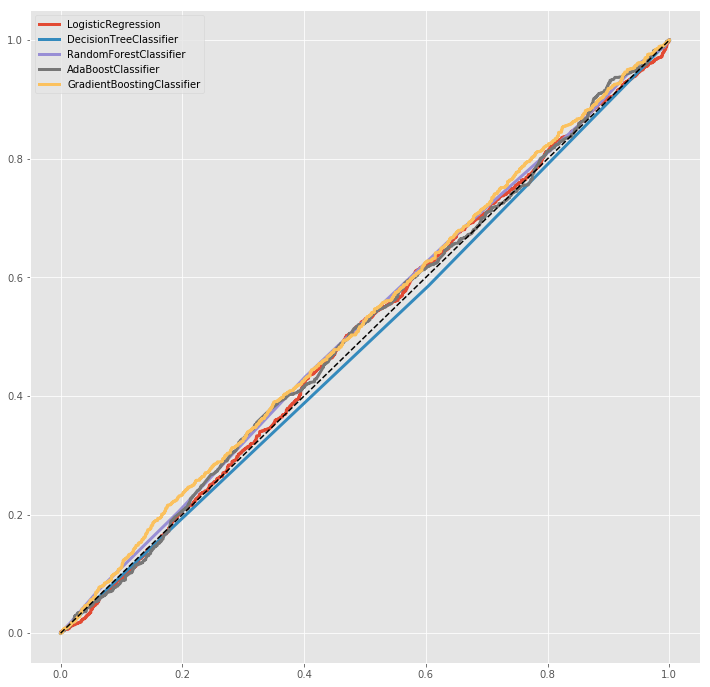

In [764]:
for classer in models:
    probas = classer.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    classer_name = classer.__class__.__name__
    #classer_name = classer.steps[1][1].__class__.__name__
    print(classer_name, roc_auc)
    plt.plot(fpr, tpr, lw=3, label=classer_name)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')

In [765]:
for classer in models[2:]:
    feat_impor = classer.feature_importances_
    x_feat = pd.DataFrame({'cols': x.columns, 'feat_impo': feat_impor})
    classer_name = classer.__class__.__name__
    print(classer_name, '\n', x_feat.sort_values(by='feat_impo', ascending=False))

RandomForestClassifier 
             cols  feat_impo
39         WILLR   0.022694
71        TRANGE   0.022014
33      STOCHF_1   0.019975
20      MINUS_DI   0.019277
32       STOCH_2   0.019026
65   HT_PHASOR_2   0.018415
38        ULTOSC   0.018300
37          TRIX   0.018233
30           RSI   0.018113
61           OBV   0.017907
18     MACDFIX_3   0.017580
14     MACDEXT_2   0.017434
15     MACDEXT_3   0.017223
63    HT_DCPHASE   0.016899
36    STOCHRSI_2   0.016780
29       ROCR100   0.016507
9             DX   0.016506
34      STOCHF_2   0.016495
60         ADOSC   0.016435
66     HT_SINE_1   0.016322
70          NATR   0.016274
31       STOCH_1   0.016251
24       PLUS_DM   0.016125
13     MACDEXT_1   0.015956
1           ADXR   0.015890
0            ADX   0.015856
12        MACD_3   0.015836
25           PPO   0.015580
64   HT_PHASOR_1   0.015301
26           ROC   0.014917
..           ...        ...
48        MAMA_1   0.010517
44           EMA   0.010375
27          ROCP   0.01

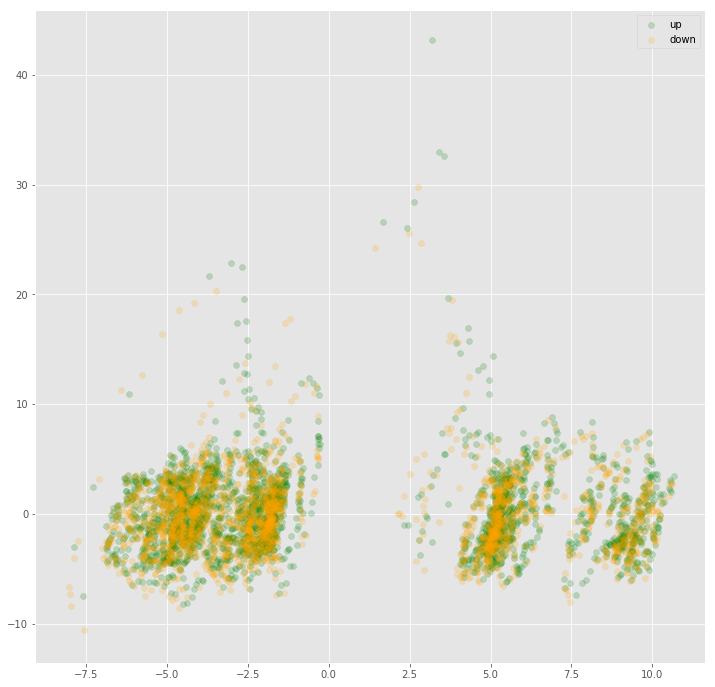

In [766]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
x_new = pca.fit_transform(x)
fig, ax = plt.subplots()
x_new_one = x_new[y==1]
x_new_zero = x_new[y==0]
ax.scatter(x_new_one[:,0], x_new_one[:,1], c='green', label='up', alpha=.2)
ax.scatter(x_new_zero[:,0], x_new_zero[:,1], c='orange', label='down', alpha=.2)
plt.legend(loc='best')

In [767]:
model_list = list(prediction_df.columns[1:])
for mod_col in model_list:
    prediction_df[mod_col] = prediction_df[mod_col].map({1:1, 0:-1}).shift(1)

In [768]:
prediction_df.head()

log_returns  average_log_return_1_sign  \
time                                                          
2016-12-08 00:11:00     0.000084                        nan   
2016-12-08 00:12:00    -0.000418                   1.000000   
2016-12-08 00:13:00    -0.000056                  -1.000000   
2016-12-08 00:14:00    -0.000149                  -1.000000   
2016-12-08 00:17:00     0.000223                  -1.000000   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-12-08 00:11:00                         nan                         nan   
2016-12-08 00:12:00                    1.000000                    1.000000   
2016-12-08 00:13:00                    1.000000                    1.000000   
2016-12-08 00:14:00                    1.000000                    1.000000   
2016-12-08 00:17:00                    1.000000                    1.000000   

                     average_log_return_60_sign  average_log_return_120_sign  \
time                                                                           
2016-12-08 00:11:00                         nan                          nan   
2016-12-08 00:12:00                    1.000000                     1.000000   
2016-12-08 00:13:00                    1.000000                     1.000000   
2016-12-08 00:14:00                    1.000000                     1.000000   
2016-12-08 00:17:00                    1.000000                     1.000000   

                     LogisticRegression  DecisionTreeClassifier  \
time                                                              
2016-12-08 00:11:00                 nan                     nan   
2016-12-08 00:12:00           -1.000000                1.000000   
2016-12-08 00:13:00            1.000000                1.000000   
2016-12-08 00:14:00           -1.000000                1.000000   
2016-12-08 00:17:00           -1.000000                1.000000   

                     RandomForestClassifier  AdaBoostClassifier  \
time                                                              
2016-12-08 00:11:00                     nan                 nan   
2016-12-08 00:12:00                1.000000            1.000000   
2016-12-08 00:13:00                1.000000            1.000000   
2016-12-08 00:14:00                1.000000            1.000000   
2016-12-08 00:17:00                1.000000            1.000000   

                     GradientBoostingClassifier  
time                                             
2016-12-08 00:11:00                         nan  
2016-12-08 00:12:00                    1.000000  
2016-12-08 00:13:00                   -1.000000  
2016-12-08 00:14:00                    1.000000  
2016-12-08 00:17:00                    1.000000

In [769]:
model_returns = ['log_returns']
for mod_col in model_list:
    model_returns.append(mod_col+'_returns')
    prediction_df[mod_col+'_returns'] = prediction_df[mod_col] * prediction_df['log_returns']

In [770]:
prediction_df.head()

log_returns  average_log_return_1_sign  \
time                                                          
2016-12-08 00:11:00     0.000084                        nan   
2016-12-08 00:12:00    -0.000418                   1.000000   
2016-12-08 00:13:00    -0.000056                  -1.000000   
2016-12-08 00:14:00    -0.000149                  -1.000000   
2016-12-08 00:17:00     0.000223                  -1.000000   

                     average_log_return_15_sign  average_log_return_30_sign  \
time                                                                          
2016-12-08 00:11:00                         nan                         nan   
2016-12-08 00:12:00                    1.000000                    1.000000   
2016-12-08 00:13:00                    1.000000                    1.000000   
2016-12-08 00:14:00                    1.000000                    1.000000   
2016-12-08 00:17:00                    1.000000                    1.000000   

                     average_log_return_60_sign  average_log_return_120_sign  \
time                                                                           
2016-12-08 00:11:00                         nan                          nan   
2016-12-08 00:12:00                    1.000000                     1.000000   
2016-12-08 00:13:00                    1.000000                     1.000000   
2016-12-08 00:14:00                    1.000000                     1.000000   
2016-12-08 00:17:00                    1.000000                     1.000000   

                     LogisticRegression  DecisionTreeClassifier  \
time                                                              
2016-12-08 00:11:00                 nan                     nan   
2016-12-08 00:12:00           -1.000000                1.000000   
2016-12-08 00:13:00            1.000000                1.000000   
2016-12-08 00:14:00           -1.000000                1.000000   
2016-12-08 00:17:00           -1.000000                1.000000   

                     RandomForestClassifier  AdaBoostClassifier  \
time                                                              
2016-12-08 00:11:00                     nan                 nan   
2016-12-08 00:12:00                1.000000            1.000000   
2016-12-08 00:13:00                1.000000            1.000000   
2016-12-08 00:14:00                1.000000            1.000000   
2016-12-08 00:17:00                1.000000            1.000000   

                     GradientBoostingClassifier  \
time                                              
2016-12-08 00:11:00                         nan   
2016-12-08 00:12:00                    1.000000   
2016-12-08 00:13:00                   -1.000000   
2016-12-08 00:14:00                    1.000000   
2016-12-08 00:17:00                    1.000000   

                     average_log_return_1_sign_returns  \
time                                                     
2016-12-08 00:11:00                                nan   
2016-12-08 00:12:00                          -0.000418   
2016-12-08 00:13:00                           0.000056   
2016-12-08 00:14:00                           0.000149   
2016-12-08 00:17:00                          -0.000223   

                     average_log_return_15_sign_returns  \
time                                                      
2016-12-08 00:11:00                                 nan   
2016-12-08 00:12:00                           -0.000418   
2016-12-08 00:13:00                           -0.000056   
2016-12-08 00:14:00                           -0.000149   
2016-12-08 00:17:00                            0.000223   

                     average_log_return_30_sign_returns  \
time                                                      
2016-12-08 00:11:00                                 nan   
2016-12-08 00:12:00                           -0.000418   
2016-12-08 00:13:00                           -0.000056   
2016-12-08 00:14:00                           -0.0

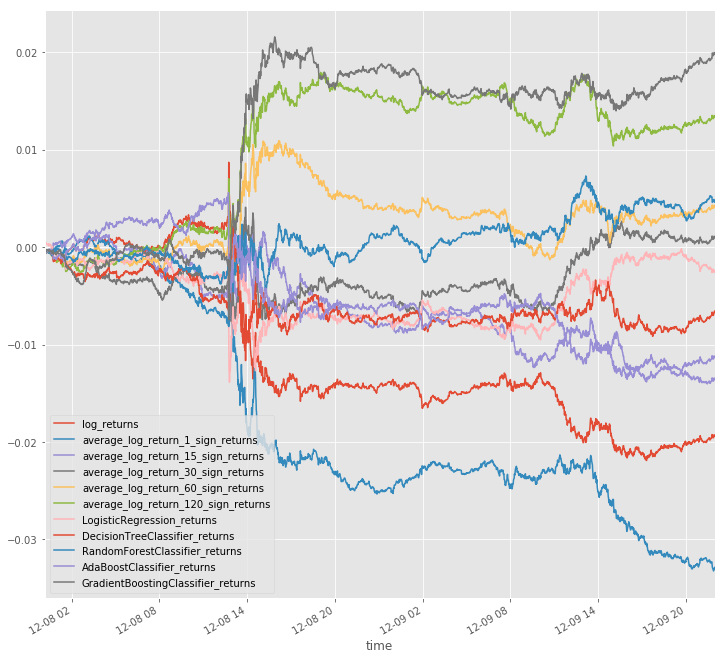

In [771]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

In [772]:
df.head(20)

volume    close     high      low     open  \
time                                                                
2016-12-06 01:28:00 -0.279643 0.814711 0.809013 0.822932 0.813022   
2016-12-06 01:29:00 -0.300604 0.813417 0.802536 0.809992 0.810432   
2016-12-06 01:30:00 -0.300604 0.822479 0.814195 0.821638 0.810432   
2016-12-06 01:32:00 -0.237720 0.826363 0.819376 0.830697 0.818201   
2016-12-06 01:33:00 -0.342526 0.827657 0.824558 0.839755 0.831150   
2016-12-06 01:34:00 -0.447333 0.823774 0.814195 0.835873 0.823381   
2016-12-06 01:35:00 -0.426372 0.822479 0.818081 0.834579 0.825971   
2016-12-06 01:36:00 -0.300604 0.822479 0.819376 0.830697 0.818201   
2016-12-06 01:37:00 -0.405410 0.826363 0.816785 0.830697 0.818201   
2016-12-06 01:38:00 -0.174836 0.847076 0.834921 0.825520 0.822086   
2016-12-06 01:39:00 -0.426372 0.860022 0.847874 0.861754 0.849278   
2016-12-06 01:40:00 -0.405410 0.862611 0.854351 0.874695 0.862227   
2016-12-06 01:41:00 -0.300604 0.880736 0.868600 0.877283 0.864817   
2016-12-06 01:42:00 -0.216759 0.874263 0.873782 0.885047 0.879061   
2016-12-06 01:43:00 -0.447333 0.872968 0.863419 0.883753 0.871291   
2016-12-06 01:44:00 -0.489256 0.870379 0.858237 0.882459 0.869996   
2016-12-06 01:45:00 -0.405410 0.861317 0.863419 0.873401 0.875176   
2016-12-06 01:47:00 -0.489256 0.858728 0.846579 0.870813 0.858343   
2016-12-06 01:48:00 -0.468294 0.852255 0.842693 0.864342 0.854458   
2016-12-06 01:49:00 -0.489256 0.849665 0.837511 0.861754 0.849278   

                     log_returns  ari_returns  log_returns_shifted  \
time                                                                 
2016-12-06 01:28:00    -0.000009    -0.000009            -0.000009   
2016-12-06 01:29:00    -0.000009    -0.000009             0.000065   
2016-12-06 01:30:00     0.000065     0.000065             0.000028   
2016-12-06 01:32:00     0.000028     0.000028             0.000009   
2016-12-06 01:33:00     0.000009     0.000009            -0.000028   
2016-12-06 01:34:00    -0.000028    -0.000028            -0.000009   
2016-12-06 01:35:00    -0.000009    -0.000009             0.000000   
2016-12-06 01:36:00     0.000000     0.000000             0.000028   
2016-12-06 01:37:00     0.000028     0.000028             0.000149   
2016-12-06 01:38:00     0.000149     0.000149             0.000093   
2016-12-06 01:39:00     0.000093     0.000093             0.000019   
2016-12-06 01:40:00     0.000019     0.000019             0.000130   
2016-12-06 01:41:00     0.000130     0.000130            -0.000046   
2016-12-06 01:42:00    -0.000046    -0.000046            -0.000009   
2016-12-06 01:43:00    -0.000009    -0.000009            -0.000019   
2016-12-06 01:44:00    -0.000019    -0.000019            -0.000065   
2016-12-06 01:45:00    -0.000065    -0.000065            -0.000019   
2016-12-06 01:47:00    -0.000019    -0.000019            -0.000046   
2016-12-06 01:48:00    -0.000046    -0.000046            -0.000019   
2016-12-06 01:49:00    -0.000019    -0.000019             0.000000   

                     target_label_direction  target_label_direction_shifted  \
time                                                                          
2016-12-06 01:28:00                0.000000                        0.000000   
2016-12-06 01:29:00                0.000000                        1.000000   
2016-12-06 01:30:00                1.000000                        1.000000   
2016-12-06 01:32:00                1.000000                        1.000000   
2016-12-06 01:33:00                1.000000                        0.000000   
2016-12-06 01:34:00                0.000000                        0.000000   
2016-12-06 01:35:00                0.000000                        1.000000   
2016-12-06 01:36:00                1.000000                        1.000000   
2016-12-06 01:37:00                1.000000                        1.000000   
2016-12-06 01:38:00                1.000000                        1.000000   
2016-12-06 01:3